# Retail Giant Assignment - Time Series Foreacasting - Notebook 2 - (Quantity)

# Initial Setup

In [1]:
# import libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the Retail Giant Dataset
data = pd.read_csv('Global2.csv')
data.columns = ['Order date', 'Segment', 'Market', 'Sales', 'Quantity', 'Profit']
data['Order date'] = pd.to_datetime(data['Order date'],format = '%d-%m-%Y')
data['month_year'] = pd.to_datetime(data['Order date']).dt.to_period('M')
data = data.set_index('month_year')
data.head(12)

Order date      Segment  Market     Sales  Quantity     Profit
month_year                                                               
2012-07    2012-07-31     Consumer      US  2309.650         7   762.1845
2013-02    2013-02-05    Corporate    APAC  3709.395         9  -288.7650
2013-10    2013-10-17     Consumer    APAC  5175.171         9   919.9710
2013-01    2013-01-28  Home Office      EU  2892.510         5   -96.5400
2013-11    2013-11-05     Consumer  Africa  2832.960         8   311.5200
2013-06    2013-06-28    Corporate    APAC  2862.675         5   763.2750
2011-11    2011-11-07     Consumer    APAC  1822.080         4   564.8400
2012-04    2012-04-14     Consumer    APAC  5244.840         6   996.4800
2014-10    2014-10-14    Corporate      US  5083.960         5  1906.4850
2012-01    2012-01-28     Consumer      US  4297.644        13 -1862.3124
2011-04    2011-04-05    Corporate      US  4164.050         5    83.2810
2012-04    2012-04-19    Corporate    APAC  4626.150         5   647.5500

In [3]:
# checking for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 51290 entries, 2012-07 to 2012-05
Freq: M
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order date  51290 non-null  datetime64[ns]
 1   Segment     51290 non-null  object        
 2   Market      51290 non-null  object        
 3   Sales       51290 non-null  float64       
 4   Quantity    51290 non-null  int64         
 5   Profit      51290 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 2.7+ MB


In [4]:
#checking the shape
data.shape

(51290, 6)

In [5]:
data.describe()

Sales      Quantity        Profit
count  51290.000000  51290.000000  51290.000000
mean     246.490581      3.476545     28.610982
std      487.565361      2.278766    174.340972
min        0.444000      1.000000  -6599.978000
25%       30.758625      2.000000      0.000000
50%       85.053000      3.000000      9.240000
75%      251.053200      5.000000     36.810000
max    22638.480000     14.000000   8399.976000

In [6]:
# merge the segment and market columns
data['market_segment'] = data['Market']+data['Segment']
data.head()

Order date      Segment  Market     Sales  Quantity    Profit  market_segment
month_year                                                                              
2012-07    2012-07-31     Consumer      US  2309.650         7  762.1845      USConsumer
2013-02    2013-02-05    Corporate    APAC  3709.395         9 -288.7650   APACCorporate
2013-10    2013-10-17     Consumer    APAC  5175.171         9  919.9710    APACConsumer
2013-01    2013-01-28  Home Office      EU  2892.510         5  -96.5400   EUHome Office
2013-11    2013-11-05     Consumer  Africa  2832.960         8  311.5200  AfricaConsumer

In [7]:
#checking the details after creation of market_segment column
print(data.shape)
data.info()

(51290, 7)
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 51290 entries, 2012-07 to 2012-05
Freq: M
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order date      51290 non-null  datetime64[ns]
 1   Segment         51290 non-null  object        
 2   Market          51290 non-null  object        
 3   Sales           51290 non-null  float64       
 4   Quantity        51290 non-null  int64         
 5   Profit          51290 non-null  float64       
 6   market_segment  51290 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 3.1+ MB


In [8]:
data.market_segment.value_counts()

APACConsumer         5699
LATAMConsumer        5321
USConsumer           5191
EUConsumer           5186
APACCorporate        3283
EUCorporate          3077
LATAMCorporate       3053
USCorporate          3020
EMEAConsumer         2538
AfricaConsumer       2381
APACHome Office      2020
LATAMHome Office     1920
USHome Office        1783
EUHome Office        1737
EMEACorporate        1574
AfricaCorporate      1312
EMEAHome Office       917
AfricaHome Office     894
CanadaConsumer        202
CanadaCorporate       110
CanadaHome Office      72
Name: market_segment, dtype: int64

# Forecasting the Sales based on Smoothing and AR Forecasting Tecniques

In [9]:
# Create a new dataframe by filtering on APAC Consumer.From Python Notebook 1(Where we found the COV and predicted the sales) we came to know based on COV that this is the most consistent segment
APAC_CONS = data[data['market_segment'] == 'APACConsumer']
APAC_CONS['Order date'] = pd.to_datetime(APAC_CONS['Order date'], format='%d-%m-%Y')
APAC_CONS['month_year'] = pd.to_datetime(APAC_CONS['Order date']).dt.to_period('M')
APAC_CONS = APAC_CONS.set_index('Order date')
APAC_CONS.sort_values(by=['month_year'], inplace=True)
APAC_CONS.head()
#APAC_CONS['Order date'] = APAC_CONS.datetime.values.astype(np.int64)
#drop the columns not required for the forecast

Segment Market     Sales  Quantity    Profit market_segment month_year
Order date                                                                         
2011-01-03  Consumer   APAC  337.6395         3 -122.8005   APACConsumer    2011-01
2011-01-03  Consumer   APAC   68.8680         2  -26.4120   APACConsumer    2011-01
2011-01-31  Consumer   APAC   62.1000         6   18.5400   APACConsumer    2011-01
2011-01-24  Consumer   APAC  139.2000         8   65.2800   APACConsumer    2011-01
2011-01-31  Consumer   APAC   32.1000         2    9.3000   APACConsumer    2011-01

In [10]:
# APAC_cons pivot to group the sales in Monthly fashion
APAC_CONS_PVT = pd.pivot_table(index = 'month_year', values = 'Quantity', aggfunc = 'sum', data = APAC_CONS)
APAC_CONS_PVT

Quantity
month_year          
2011-01          214
2011-02          151
2011-03          283
2011-04          148
2011-05          244
2011-06          322
2011-07          212
2011-08          325
2011-09          391
2011-10          401
2011-11          504
2011-12          511
2012-01          279
2012-02          277
2012-03          132
2012-04          218
2012-05          434
2012-06          507
2012-07          156
2012-08          516
2012-09          424
2012-10          550
2012-11          664
2012-12          433
2013-01          344
2013-02          263
2013-03          310
2013-04          261
2013-05          694
2013-06          675
2013-07          378
2013-08          508
2013-09          662
2013-10          518
2013-11          612
2013-12          611
2014-01          423
2014-02          334
2014-03          408
2014-04          402
2014-05          596
2014-06          721
2014-07          377
2014-08          816
2014-09          658
2014-10          885
2014-11          829
2014-12          833

# Outlier Detection

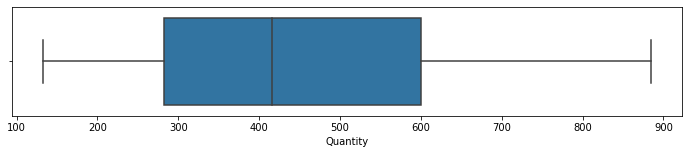

In [11]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=APAC_CONS_PVT['Quantity'],whis=1.5)
# No Outlier treatment will be done as no outliers

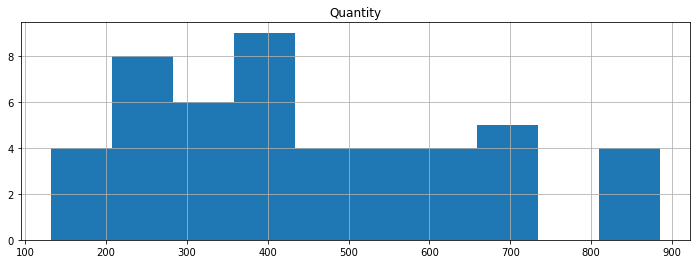

In [12]:
fig = APAC_CONS_PVT.hist(figsize = (12,4))

# Plot Time Series Data

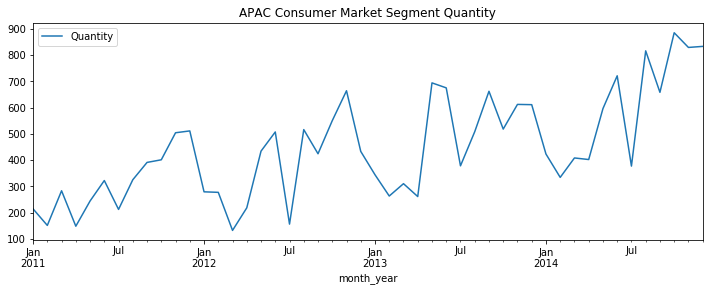

In [13]:
APAC_CONS_PVT.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('APAC Consumer Market Segment Quantity')
plt.show(block=False)

# Time Series Decomposition

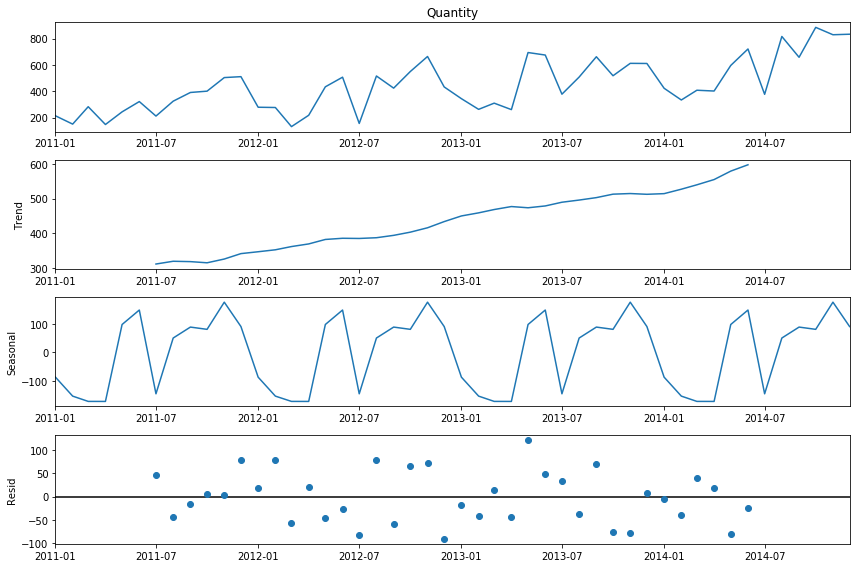

In [14]:
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams['figure.figsize'] = 12, 8
APAC_CONS_PVT.index=APAC_CONS_PVT.index.to_timestamp()
#APAC_CONS_PVT.head()
decomposition = sm.tsa.seasonal_decompose(APAC_CONS_PVT.Quantity, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

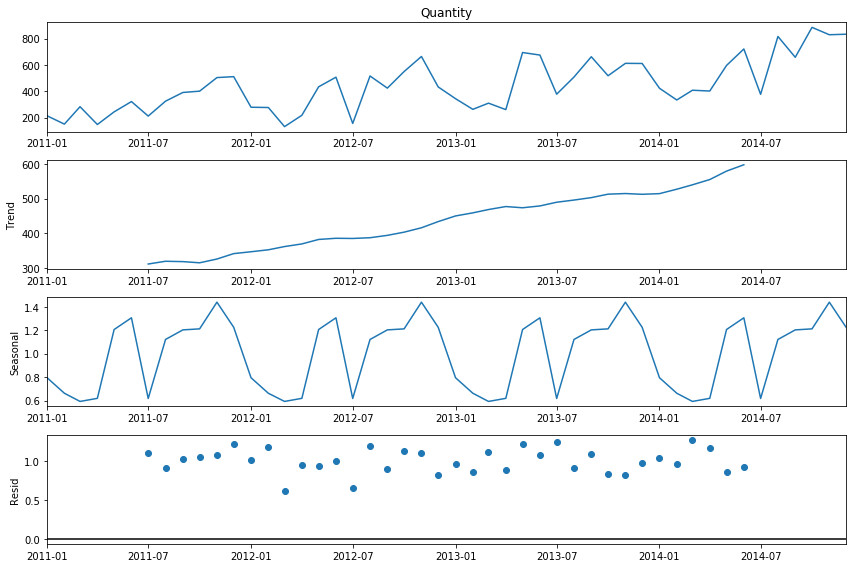

In [15]:
decomposition = sm.tsa.seasonal_decompose(APAC_CONS_PVT.Quantity, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

#### After the decomposition we can see that the data has trend as well as seasonality.Also the levels are increasing. Hence we can consider the Holt-Winter's Exponential Smoothing-Multiplicative method for forecasting in Exponential Smoothing techniques. In the Auto Regression series of models, the SARIMA model will give the best results as it will take into consideration both trend as well as seasonality.

In [16]:
# Build and Evaluate the Time Series Forecast
train_len = 42
train = APAC_CONS_PVT[0:train_len] # first 42 months as training set
test = APAC_CONS_PVT[train_len:] # last 6 months as out-of-time test set

In [17]:
print(train.shape)
print(test.shape)

(42, 1)
(6, 1)


# Exponential smoothing methods

## Simple exponential smoothing

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Quantity'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

### Plot train, test and forecast

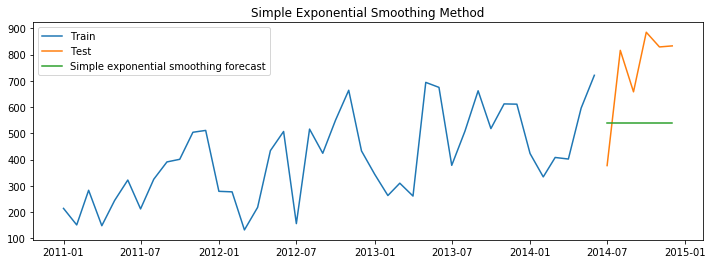

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [20]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_ses['ses_forecast'])/test['Quantity'])*100,2)

results = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0  Simple exponential smoothing forecast  261.71  34.15

## Holt's Exponential Smoothing

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Quantity']) ,seasonal_periods=12 ,trend='multiplicative', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 1.4742410088814688e-10, 'smoothing_slope': 0.0, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 214.00007321102916, 'initial_slope': 1.02558905998653, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

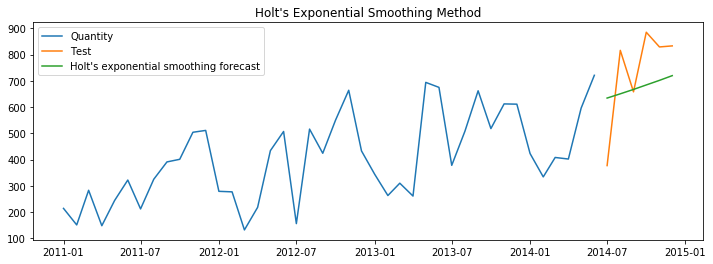

In [22]:
plt.figure(figsize=(12,4))
plt.plot( train['Quantity'], label='Quantity')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [23]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_holt['holt_forecast'])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0  Simple exponential smoothing forecast  261.71  34.15
0    Holt's exponential smoothing method  164.83  23.59

## Holt Winters' Exponential Smoothing (additive method)

In [24]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Quantity']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.05263157894736842, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.47368421052631576, 'damping_slope': nan, 'initial_level': 315.0, 'initial_slope': 6.138888888888889, 'initial_seasons': array([-101., -164.,  -32., -167.,  -71.,    7., -103.,   10.,   76.,
         86.,  189.,  196.]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

In [25]:
plt.figure(figsize=(12,4))
plt.plot( train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [26]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_hwa['hw_forecast'])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0  Simple exponential smoothing forecast  261.71  34.15
0    Holt's exponential smoothing method  164.83  23.59
0          Holt Winters' additive method  156.24  15.98

## Holt Winter's Exponential Smoothing (multiplicative method)

In [27]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Quantity']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.05263157894736842, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.47368421052631576, 'damping_slope': nan, 'initial_level': 315.0, 'initial_slope': 6.138888888888889, 'initial_seasons': array([0.67936508, 0.47936508, 0.8984127 , 0.46984127, 0.77460317,
       1.02222222, 0.67301587, 1.03174603, 1.24126984, 1.27301587,
       1.6       , 1.62222222]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

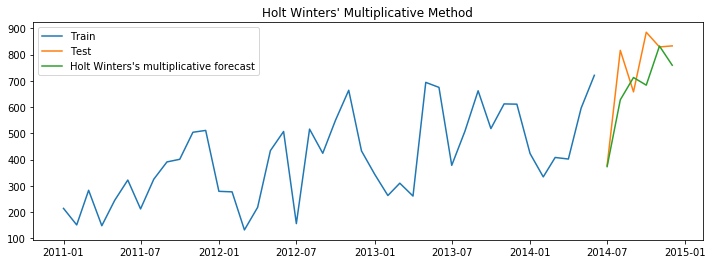

In [28]:
plt.figure(figsize=(12,4))
plt.plot( train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s multiplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Multiplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [29]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_hwm['hw_forecast'])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0  Simple exponential smoothing forecast  261.71  34.15
0    Holt's exponential smoothing method  164.83  23.59
0          Holt Winters' additive method  156.24  15.98
0    Holt Winters' multiplicative method  118.69  10.73

# Auto Regressive methods

## Checking the stationarity

### Augmented Dickey-Fuller (ADF) test

In [30]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(APAC_CONS_PVT['Quantity'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])
# p-value is greater than 0.05.The series is not stationary.

ADF Statistic: 0.293145
Critical Values @ 0.05: -2.94
p-value: 0.977028


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [31]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(APAC_CONS_PVT['Quantity'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

# series is not stationary as p-value is less than 0.05

KPSS Statistic: 0.593099
Critical Values @ 0.05: 0.46
p-value: 0.023264


### Box Cox transformation for making variance constant

In [32]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(APAC_CONS_PVT['Quantity'], lmbda=0), index = APAC_CONS_PVT.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

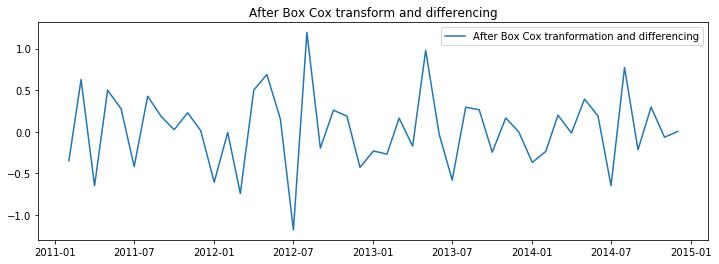

In [33]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), APAC_CONS_PVT.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [34]:
# Before dropping the NA values
data_boxcox_diff

month_year
2011-01-01         NaN
2011-02-01   -0.348696
2011-03-01    0.628167
2011-04-01   -0.648235
2011-05-01    0.499956
2011-06-01    0.277383
2011-07-01   -0.417965
2011-08-01    0.427239
2011-09-01    0.184882
2011-10-01    0.025254
2011-11-01    0.228615
2011-12-01    0.013793
2012-01-01   -0.605158
2012-02-01   -0.007194
2012-03-01   -0.741216
2012-04-01    0.501693
2012-05-01    0.688549
2012-06-01    0.155466
2012-07-01   -1.178655
2012-08-01    1.196251
2012-09-01   -0.196373
2012-10-01    0.260185
2012-11-01    0.188364
2012-12-01   -0.427544
2013-01-01   -0.230096
2013-02-01   -0.268488
2013-03-01    0.164418
2013-04-01   -0.172052
2013-05-01    0.977952
2013-06-01   -0.027759
2013-07-01   -0.579818
2013-08-01    0.295587
2013-09-01    0.264784
2013-10-01   -0.245290
2013-11-01    0.166757
2013-12-01   -0.001635
2014-01-01   -0.367725
2014-02-01   -0.236231
2014-03-01    0.200126
2014-04-01   -0.014815
2014-05-01    0.393789
2014-06-01    0.190398
2014-07-01   -0.648394


In [35]:
data_boxcox_diff.dropna(inplace=True)

In [36]:
# After dropping NA values
data_boxcox_diff

month_year
2011-02-01   -0.348696
2011-03-01    0.628167
2011-04-01   -0.648235
2011-05-01    0.499956
2011-06-01    0.277383
2011-07-01   -0.417965
2011-08-01    0.427239
2011-09-01    0.184882
2011-10-01    0.025254
2011-11-01    0.228615
2011-12-01    0.013793
2012-01-01   -0.605158
2012-02-01   -0.007194
2012-03-01   -0.741216
2012-04-01    0.501693
2012-05-01    0.688549
2012-06-01    0.155466
2012-07-01   -1.178655
2012-08-01    1.196251
2012-09-01   -0.196373
2012-10-01    0.260185
2012-11-01    0.188364
2012-12-01   -0.427544
2013-01-01   -0.230096
2013-02-01   -0.268488
2013-03-01    0.164418
2013-04-01   -0.172052
2013-05-01    0.977952
2013-06-01   -0.027759
2013-07-01   -0.579818
2013-08-01    0.295587
2013-09-01    0.264784
2013-10-01   -0.245290
2013-11-01    0.166757
2013-12-01   -0.001635
2014-01-01   -0.367725
2014-02-01   -0.236231
2014-03-01    0.200126
2014-04-01   -0.014815
2014-05-01    0.393789
2014-06-01    0.190398
2014-07-01   -0.648394
2014-08-01    0.772169


### Augmented Dickey-Fuller (ADF) test

In [37]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])
# p value is less than 0.05.The series is stationary.

ADF Statistic: -6.731694
Critical Values @ 0.05: -2.95
p-value: 0.000000


In [38]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
# p value is greater than 0.05.The series is stationary

KPSS Statistic: 0.157717
Critical Values @ 0.05: 0.46
p-value: 0.100000


## Autocorrelation function (ACF)

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 1)
plt.show()

## Partial autocorrelation function (PACF)

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 1)
plt.show()

In [41]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [42]:
train_data_boxcox_diff

month_year
2011-02-01   -0.348696
2011-03-01    0.628167
2011-04-01   -0.648235
2011-05-01    0.499956
2011-06-01    0.277383
2011-07-01   -0.417965
2011-08-01    0.427239
2011-09-01    0.184882
2011-10-01    0.025254
2011-11-01    0.228615
2011-12-01    0.013793
2012-01-01   -0.605158
2012-02-01   -0.007194
2012-03-01   -0.741216
2012-04-01    0.501693
2012-05-01    0.688549
2012-06-01    0.155466
2012-07-01   -1.178655
2012-08-01    1.196251
2012-09-01   -0.196373
2012-10-01    0.260185
2012-11-01    0.188364
2012-12-01   -0.427544
2013-01-01   -0.230096
2013-02-01   -0.268488
2013-03-01    0.164418
2013-04-01   -0.172052
2013-05-01    0.977952
2013-06-01   -0.027759
2013-07-01   -0.579818
2013-08-01    0.295587
2013-09-01    0.264784
2013-10-01   -0.245290
2013-11-01    0.166757
2013-12-01   -0.001635
2014-01-01   -0.367725
2014-02-01   -0.236231
2014-03-01    0.200126
2014-04-01   -0.014815
2014-05-01    0.393789
2014-06-01    0.190398
Freq: MS, dtype: float64

## Auto regression method (AR)

In [43]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.031031
ar.L1.y   -0.354124
dtype: float64


### Recover original time series

In [44]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

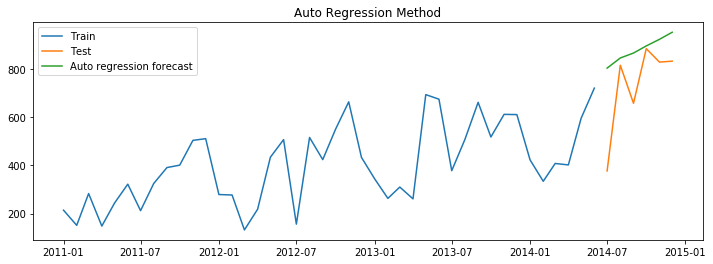

In [45]:
plt.figure(figsize=(12,4))
plt.plot(train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [46]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_ar['ar_forecast'][test.index.min():])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0  Simple exponential smoothing forecast  261.71  34.15
0    Holt's exponential smoothing method  164.83  23.59
0          Holt Winters' additive method  156.24  15.98
0    Holt Winters' multiplicative method  118.69  10.73
0             Autoregressive (AR) method  204.28  29.30

## Moving average method (MA)

In [47]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.022029
ma.L1.y   -1.000000
dtype: float64


### Recover original time series

In [48]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

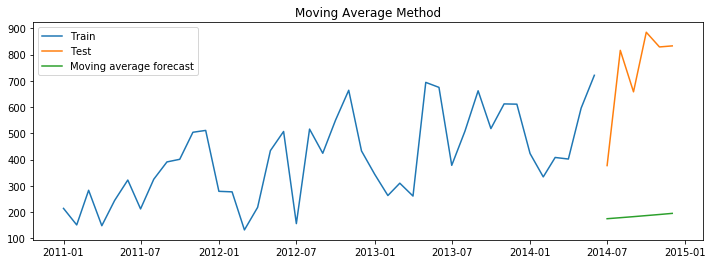

In [49]:
plt.figure(figsize=(12,4))
plt.plot(APAC_CONS_PVT['Quantity'][:train_len], label='Train')
plt.plot(APAC_CONS_PVT['Quantity'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [50]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_ma['ma_forecast'][test.index.min():])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0  Simple exponential smoothing forecast  261.71  34.15
0    Holt's exponential smoothing method  164.83  23.59
0          Holt Winters' additive method  156.24  15.98
0    Holt Winters' multiplicative method  118.69  10.73
0             Autoregressive (AR) method  204.28  29.30
0             Moving Average (MA) method  573.80  72.76

## Auto regression moving average method (ARMA)

In [51]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.022378
ar.L1.y    0.249097
ma.L1.y   -0.999935
dtype: float64


### Recover original time series

In [52]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

In [53]:
plt.figure(figsize=(12,4))
plt.plot(APAC_CONS_PVT['Quantity'][:train_len-1], label='Train')
plt.plot(APAC_CONS_PVT['Quantity'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [54]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_arma['arma_forecast'][train_len-1:])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0        Simple exponential smoothing forecast  261.71  34.15
0          Holt's exponential smoothing method  164.83  23.59
0                Holt Winters' additive method  156.24  15.98
0          Holt Winters' multiplicative method  118.69  10.73
0                   Autoregressive (AR) method  204.28  29.30
0                   Moving Average (MA) method  573.80  72.76
0  Autoregressive moving average (ARMA) method  489.40  59.24

## Auto regressive integrated moving average (ARIMA)

In [55]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.022378
ar.L1.D.y    0.249097
ma.L1.D.y   -0.999935
dtype: float64


### Recover original time series forecast

In [56]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

In [57]:
plt.figure(figsize=(12,4))
plt.plot(train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [58]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_arima['arima_forecast'][test.index.min():])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0              Simple exponential smoothing forecast  261.71  34.15
0                Holt's exponential smoothing method  164.83  23.59
0                      Holt Winters' additive method  156.24  15.98
0                Holt Winters' multiplicative method  118.69  10.73
0                         Autoregressive (AR) method  204.28  29.30
0                         Moving Average (MA) method  573.80  72.76
0        Autoregressive moving average (ARMA) method  489.40  59.24
0  Autoregressive integrated moving average (ARIM...  489.40  59.24

## Seasonal auto regressive integrated moving average (SARIMA)

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.017662
ma.L1      -0.992902
ar.S.L12   -0.407653
ma.S.L12   -0.990197
sigma2      0.033180
dtype: float64


### Recover original time series forecast

In [60]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

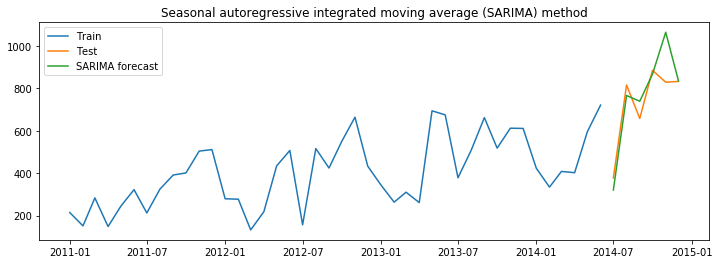

In [61]:
plt.figure(figsize=(12,4))
plt.plot(train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [62]:
rmse = np.sqrt(mean_squared_error(test['Quantity'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Quantity']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Quantity'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method    RMSE   MAPE
0              Simple exponential smoothing forecast  261.71  34.15
0                Holt's exponential smoothing method  164.83  23.59
0                      Holt Winters' additive method  156.24  15.98
0                Holt Winters' multiplicative method  118.69  10.73
0                         Autoregressive (AR) method  204.28  29.30
0                         Moving Average (MA) method  573.80  72.76
0        Autoregressive moving average (ARMA) method  489.40  59.24
0  Autoregressive integrated moving average (ARIM...  489.40  59.24
0  Seasonal autoregressive integrated moving aver...  106.62  10.69

#### ARIMAX and SARIMAX models will not be applicable as there are no exogenous variables provided which impact the forecasting of Quantity.

# Conclusion

#### The best forecasting tehnique in Exponential Smoothing is the Holt Winter's Exponential Smoothing with the multiplicative method.The MAPE and RMSE values are significantly lower than other smoothing methods.It captures the seasonality as well as trend of the forecast of the next 6 months effectively.
#### #### The best forecasting tehnique in Auto Regression Models is the Seasonal Autoregressive Integrated Moving Average method (SARIMA).The MAPE and RMSE values are significantly lower than other AR techniques.It captures the seasonality as well as trend of the forecast of the next 6 months effectively.
#### This matches with the assumptions of the forecasting techniques we predicted earlier based on the flowchart for forecasting the Quantity.